# Prelim

This notebook explains how to handle filtering and analysis when multiple samples need to be analyzed together. We will use the multiome data of the T-cell depleted bone marrow in the [SEACells](https://www.google.com/search?q=seacells+biorxiv&oq=seacells+biorxi&aqs=chrome.0.0i512j69i57.3474j0j7&sourceid=chrome&ie=UTF-8) manuscript. The data was generated using two 10X channels.

The initial part of the notebook shows how to handle multiple samples. After combinig the two samples, the notebook follows the same flow of the multiome single-cell sample notebook. 

Data available at `s3://fh-pi-setty-m-eco-public/single-cell-primers/multi-sample-multiome/`

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
import pyranges as pr
import warnings

In [3]:
import palantir 
import phenograph
import harmony

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [6]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [7]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc


def _dot_func(x, y):
    return x.dot(y)


def impute_data(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)

    # RUn in parallel
    seq = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])
    res = Parallel(n_jobs=-1)(delayed(_dot_func)(T_steps, ad.X[:, seq[i - 1]:seq[i]]) for i in range(1, len(seq)))
    imputed_data = hstack(res)
    imputed_data = imputed_data.todense()
    imputed_data[imputed_data < 1e-2] = 0
    gc.collect()

    return imputed_data

# Load data

In [8]:
# Copy over data to the current working directory
!aws s3 sync s3://fh-pi-setty-m-eco-public/single-cell-primers/multi-sample-multiome/ multi-sample-multiome/

download: s3://fh-pi-setty-m-eco-public/single-cell-primers/multi-sample-multiome/features.tsv.gz to multi-sample-multiome/features.tsv.gz
download: s3://fh-pi-setty-m-eco-public/single-cell-primers/multi-sample-multiome/rep1w to multi-sample-multiome/rep1w
download: s3://fh-pi-setty-m-eco-public/single-cell-primers/multi-sample-multiome/rep2/atac_fragments.tsv.gz.tbi to multi-sample-multiome/rep2/atac_fragments.tsv.gz.tbi
download: s3://fh-pi-setty-m-eco-public/single-cell-primers/multi-sample-multiome/rep1/atac_fragments.tsv.gz.tbi to multi-sample-multiome/rep1/atac_fragments.tsv.gz.tbi
download: s3://fh-pi-setty-m-eco-public/single-cell-primers/multi-sample-multiome/rep1/per_barcode_metrics.csv to multi-sample-multiome/rep1/per_barcode_metrics.csv
download: s3://fh-pi-setty-m-eco-public/single-cell-primers/multi-sample-multiome/rep1/filtered_feature_bc_matrix.h5 to multi-sample-multiome/rep1/filtered_feature_bc_matrix.h5
download: s3://fh-pi-setty-m-eco-public/single-cell-primers/mu

In [9]:
data_dir = 'multi-sample-multiome/'

In [10]:
# RNA and ATAC data
samples = ['rep1', 'rep2']

rna_ad_dict, atac_ad_dict = dict(), dict()
for r in samples:
    comb_ad = sc.read_10x_h5(data_dir + r + '/filtered_feature_bc_matrix.h5', gex_only=False)
    # Use a name which is indicative of the data
    comb_ad.obs_names = 'bm_multiome_' + r + '#'+ comb_ad.obs_names
    comb_ad.uns['features'] = pd.read_csv(data_dir + "features.tsv.gz")
    # RNA
    rna_ad_dict[r] = comb_ad[:, comb_ad.var['feature_types'] == 'Gene Expression']
    rna_ad_dict[r].var_names_make_unique()
    rna_ad_dict[r].obs['sample'] = r
    
    # ATAC
    atac_ad_dict[r] = comb_ad[:, comb_ad.var['feature_types'] == 'Peaks']
    atac_ad_dict[r].var_names_make_unique()


/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
# Cells from each sample 
sample_cells = dict()
for sample in samples:
    sample_cells[sample] = rna_ad_dict[sample].obs_names

In [12]:
# Per barcode metrics 
bc_metrics_dict = dict()
for sample in samples:
    bc_metrics_dict[sample] = pd.read_csv(data_dir + r + '/per_barcode_metrics.csv', index_col=0)
    bc_metrics_dict[sample].index = 'bm_multiome_' + sample + '#' +bc_metrics_dict[sample].index 
    # FRIP
    bc_metrics_dict[sample]['FRIP'] = bc_metrics_dict[sample]['atac_peak_region_fragments']/bc_metrics_dict[sample]['atac_fragments']
    
    # Update subset of cells
    sample_cells[sample] = sample_cells[sample].intersection(bc_metrics_dict[sample].index)


# Preprocess

## QC

In [13]:
# QC metrics include mitochondrial fractions from scanpy 
for r in samples:
    rna_ad = rna_ad_dict[r]
    rna_ad.var['mt'] = rna_ad.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(rna_ad, qc_vars=['mt'], inplace=True, percent_top=None, log1p=False, )

In [14]:
# QC metrics include mitochondrial fractions from scanpy 
for r in samples:
    atac_ad = atac_ad_dict[r]
    sc.pp.calculate_qc_metrics(atac_ad, inplace=True, percent_top=None, log1p=False, )

### Filtering cells based on RNA

Text(0.5, 0.98, 'log10 molecule counts')

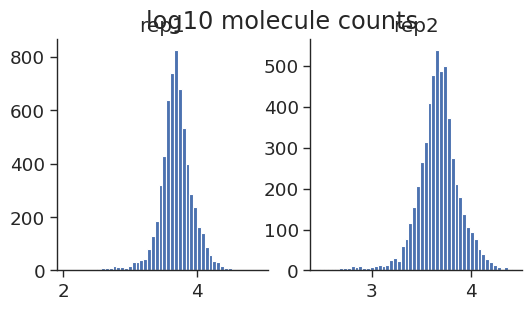

In [15]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    ax.hist(np.log10(rna_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.set_title(sample)
sns.despine()
plt.suptitle('log10 molecule counts')

Text(0.5, 0.98, 'log10 molecule counts')

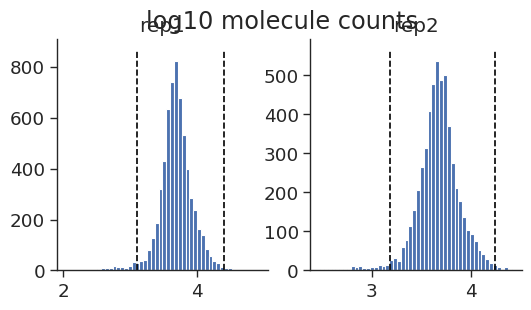

In [16]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    THRESHOLDS = np.log10(np.percentile((rna_ad.obs['total_counts']), [2.5, 99.5]))
    ax.hist(np.log10(rna_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.vlines(THRESHOLDS, ax.get_ylim()[0], ax.get_ylim()[1], color='black', linestyle='--')
    ax.set_title(sample)
sns.despine()
plt.suptitle('log10 molecule counts')

In [17]:
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    cells = sample_cells[sample]
    
    # Filter
    THRESHOLDS = np.percentile((rna_ad.obs['total_counts']), [2.5, 99.5])
    sample_cells[sample] = cells[(rna_ad.obs['total_counts'][cells] > THRESHOLDS[0]) & \
        (rna_ad.obs['total_counts'][cells] < THRESHOLDS[1])]

Text(0.5, 0.98, 'log10 molecule counts')

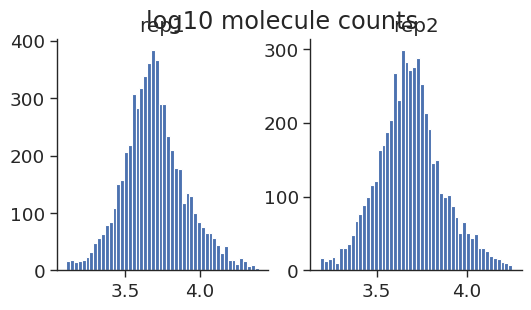

In [18]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    ax.hist(np.log10(rna_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.set_title(sample)
sns.despine()
plt.suptitle('log10 molecule counts')

### Filtering based on ATAC

Text(0.5, 0.98, 'Fraction of reads in peaks')

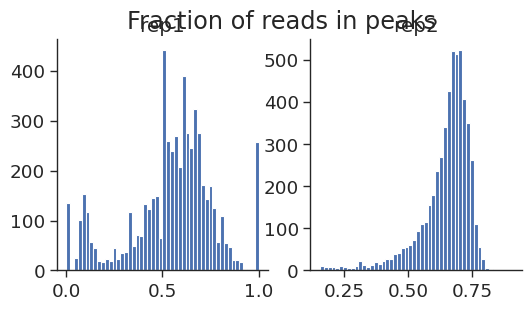

In [19]:
## CAUTION: CellRanger peak calling is unreliable and we only use it here to filter cells with low 
##          fraction of reads in peaks. This is ok since CellRanger peak caller dramatically over estimates 
##          the peak widths. We might incur some false negatives, but thats an acceptable error for filtering   
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    ax.hist(bc_metrics_dict[sample]['FRIP'][sample_cells[sample]], 50)
    ax.set_title(sample)
sns.despine()
plt.suptitle('Fraction of reads in peaks')

In [20]:
# Given the uneven distribution, we will skip filtering by ATAC here.
THRESHOLD = 00
for sample in samples:
    sample_cells[sample] = sample_cells[sample][bc_metrics_dict[sample]['FRIP'][sample_cells[sample]] > THRESHOLD]

Text(0.5, 0.98, 'log10 molecule counts')

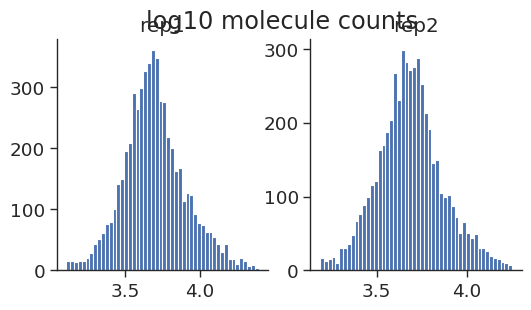

In [21]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    ax.hist(np.log10(rna_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.set_title(sample)
sns.despine()
plt.suptitle('log10 molecule counts')

### Filter based on mitochondria

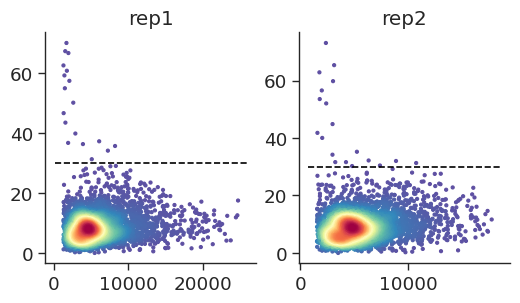

In [22]:
# Mitochondrial fractions compared to total molecules (colored by density)
MITO_THRESHOLD = 30
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip(samples, fig):
    rna_ad = rna_ad_dict[sample]
    
    # Density 
    x,y,dens = palantir.plot.density_2d(rna_ad.obs['total_counts'][sample_cells[sample]], 
               rna_ad.obs['pct_counts_mt'][sample_cells[sample]])
    
    ax.scatter(x, y, c=dens, s=5)
    ax.hlines(MITO_THRESHOLD, ax.get_xlim()[0], ax.get_xlim()[1], color='black', linestyle='--')
    ax.set_title(sample)
sns.despine()



In [23]:
for sample in samples:
    cells = sample_cells[sample]
    sample_cells[sample] = cells[rna_ad_dict[sample].obs['pct_counts_mt'][cells] < MITO_THRESHOLD]

## Combine samples 

In [24]:
sample = samples[0]
ad = rna_ad_dict[sample][sample_cells[sample]]
for sample in samples[1:]:
    ad = ad.concatenate(rna_ad_dict[sample][sample_cells[sample]], 
                            index_unique=None, batch_key='batch')
ad

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 11015 × 36601
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1'

In [25]:
# Clean up var object
ad.var = pd.DataFrame(index=ad.var_names)

In [26]:
# Filter cells
sc.pp.filter_genes(ad, min_cells=50)

In [27]:
ad

AnnData object with n_obs × n_vars = 11015 × 17246
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'n_cells'

In [28]:
raw_ad = ad.copy()

### Doublet scores  (post filtering)

In [29]:
# Install scrublet using `pip install scrublet`
import scrublet as scr

In [30]:
doublet_scores = pd.Series(0.0, index=ad.obs_names)

for sample in samples:
    cells = ad.obs_names[ad.obs['sample'] == sample]
    scrub = scr.Scrublet(raw_ad[cells, :].X)
    scores, predicted_doublets = scrub.scrub_doublets()
    doublet_scores[cells] = scores

ad.obs['DoubletScores'] = doublet_scores.values

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.74
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 16.4%
Elapsed time: 9.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.38
Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 46.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.4%
Elapsed time: 5.2 seconds


## Analysis

In [31]:
# Normalize and log transform
sc.pp.normalize_per_cell(ad)
log_transform(ad)

In [32]:
# Highly variable genes [Num. of genes is a paramter, typically 1.5-2.5k genes work well]
sc.pp.highly_variable_genes(ad, flavor='cell_ranger', n_top_genes=1500)
ad

AnnData object with n_obs × n_vars = 11015 × 17246
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [33]:
# PCA
# 50 comps is an approxmiation here - choose number of components by knee point or fraction of explained variance
n_comps = 50
sc.pp.pca(ad, use_highly_variable=True, n_comps=n_comps)

In [34]:
# UMAP and Leiden - requires the computation of nearest neighbors
# Ignore numba warnings in neighborhood computation
warnings.filterwarnings('ignore')
sc.pp.neighbors(ad, use_rep='X_pca')
warnings.filterwarnings('default')
sc.tl.umap(ad)
sc.tl.leiden(ad)
ad

2023-01-25 14:38:27.588565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 14:38:27.748888: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-25 14:38:27.754430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-25 14:38:27.754445: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

AnnData object with n_obs × n_vars = 11015 × 17246
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [35]:
# Diffusion maps 
warnings.filterwarnings('ignore')
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_pca'], index=ad.obs_names))
warnings.filterwarnings('default')
ad.obsp['DM_Kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors'] = dm_res['EigenVectors'].values
ad.uns['DMEigenValues'] = dm_res['EigenValues'].values
ad

Determing nearest neighbor graph...


AnnData object with n_obs × n_vars = 11015 × 17246
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'DMEigenValues'
    obsm: 'X_pca', 'X_umap', 'DM_EigenVectors'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'DM_Kernel'

In [36]:
# Force directed layout
ad.obsm['X_FDL'] = harmony.plot.force_directed_layout(dm_res['kernel']).values

100%|██████████| 500/500 [01:23<00:00,  6.00it/s]

BarnesHut Approximation  took  40.62  seconds
Repulsion forces  took  38.00  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  2.07  seconds
AdjustSpeedAndApplyForces step  took  1.16  seconds


In [37]:
# Imputation
from scipy.sparse import csr_matrix
ad.layers['MAGIC_imputed_data'] = csr_matrix(impute_data(dm_res, ad))

# Visualize results

In [38]:
ad.obs['log_n_counts'] = np.log10(ad.obs['total_counts'])

Note that in the sample the two samples coincide very clearly indicating that there is no batch effect. This is completely expected since the two replicates were generated using cells from the same individual. Separation of cells based on sample here is a good diagnostic for batch effects

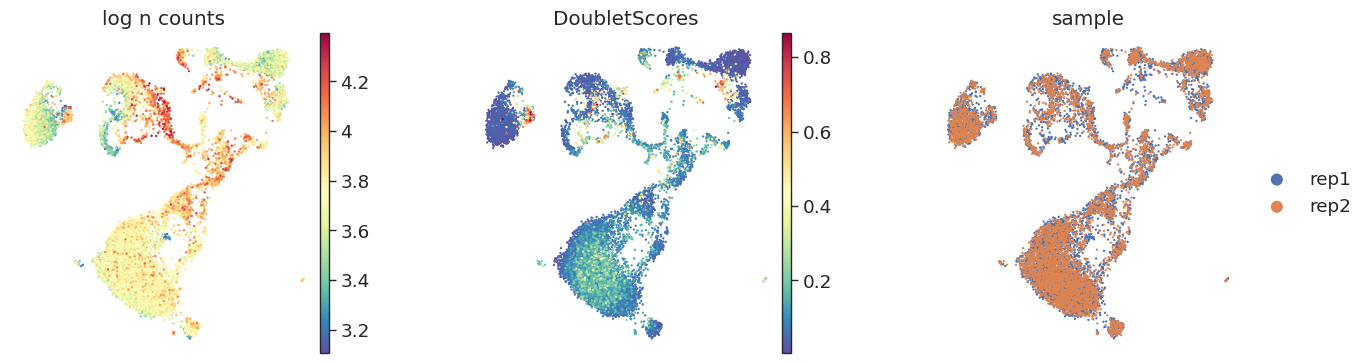

In [39]:
sc.pl.scatter(ad, basis='umap', color=['log_n_counts', 'DoubletScores', 'sample'], frameon=False)

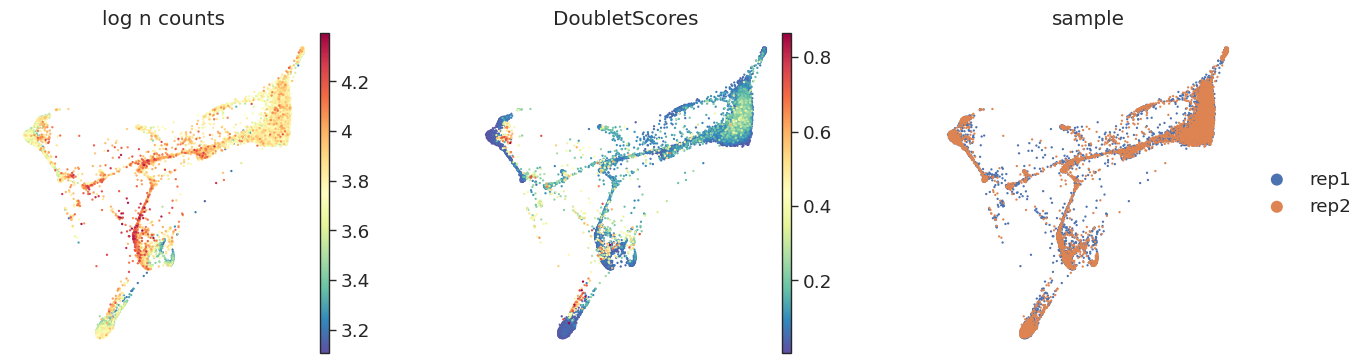

In [40]:
sc.pl.scatter(ad, basis='FDL', color=['log_n_counts', 'DoubletScores', 'sample'], frameon=False)

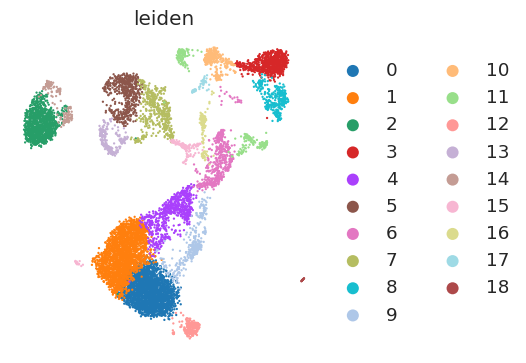

In [41]:
sc.pl.scatter(ad, basis='umap', color=['leiden'], frameon=False)

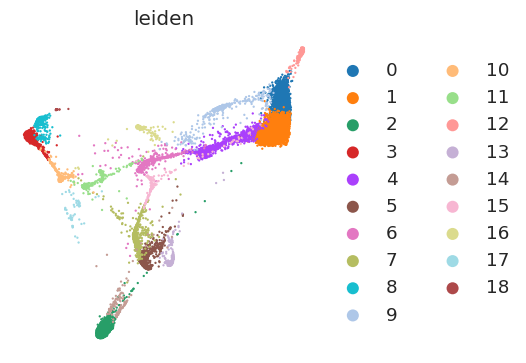

In [42]:
sc.pl.scatter(ad, basis='FDL', color=['leiden'], frameon=False)

# Celltype annotation

In [43]:
marker_dict = {'HSPC': ['CD34'], 
               'CLP/Bcells': ["CD79B", "EBF1", "PAX5"],
               'B cells': ["CD19"], 
               'Ery': ['GATA1', 'GATA2'], 
               'DC': ['IRF4', 'IRF8'],
               'Mono': ['MPO'],
               'Megakaryocyte': ['ITGA2B'], 
              }

categories: 0, 1, 2, etc.
var_group_labels: HSPC, CLP/Bcells, B cells, etc.


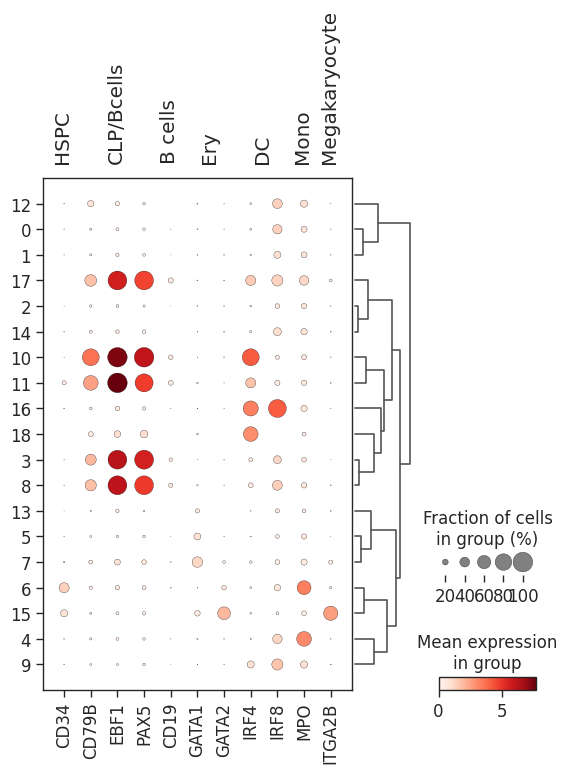

In [44]:
sc.pl.dotplot(ad, marker_dict, 'leiden', dendrogram=True)

In [45]:
genes = pd.Series([
    "CD34", "CD38", # HSPC
    "CD79B", "EBF1", "PAX5", # CLP / B cell lineage 
    "CD19", "CD20", # Mature B cell markers
    "GATA1",  # Erythroid lineage
    "IRF8", # DC lineage
    "MPO", # Monocyte lineage
    "ITGA2B", #CD41 - Megakaryocyte,     
])
genes = genes[genes.isin(ad.var_names)]

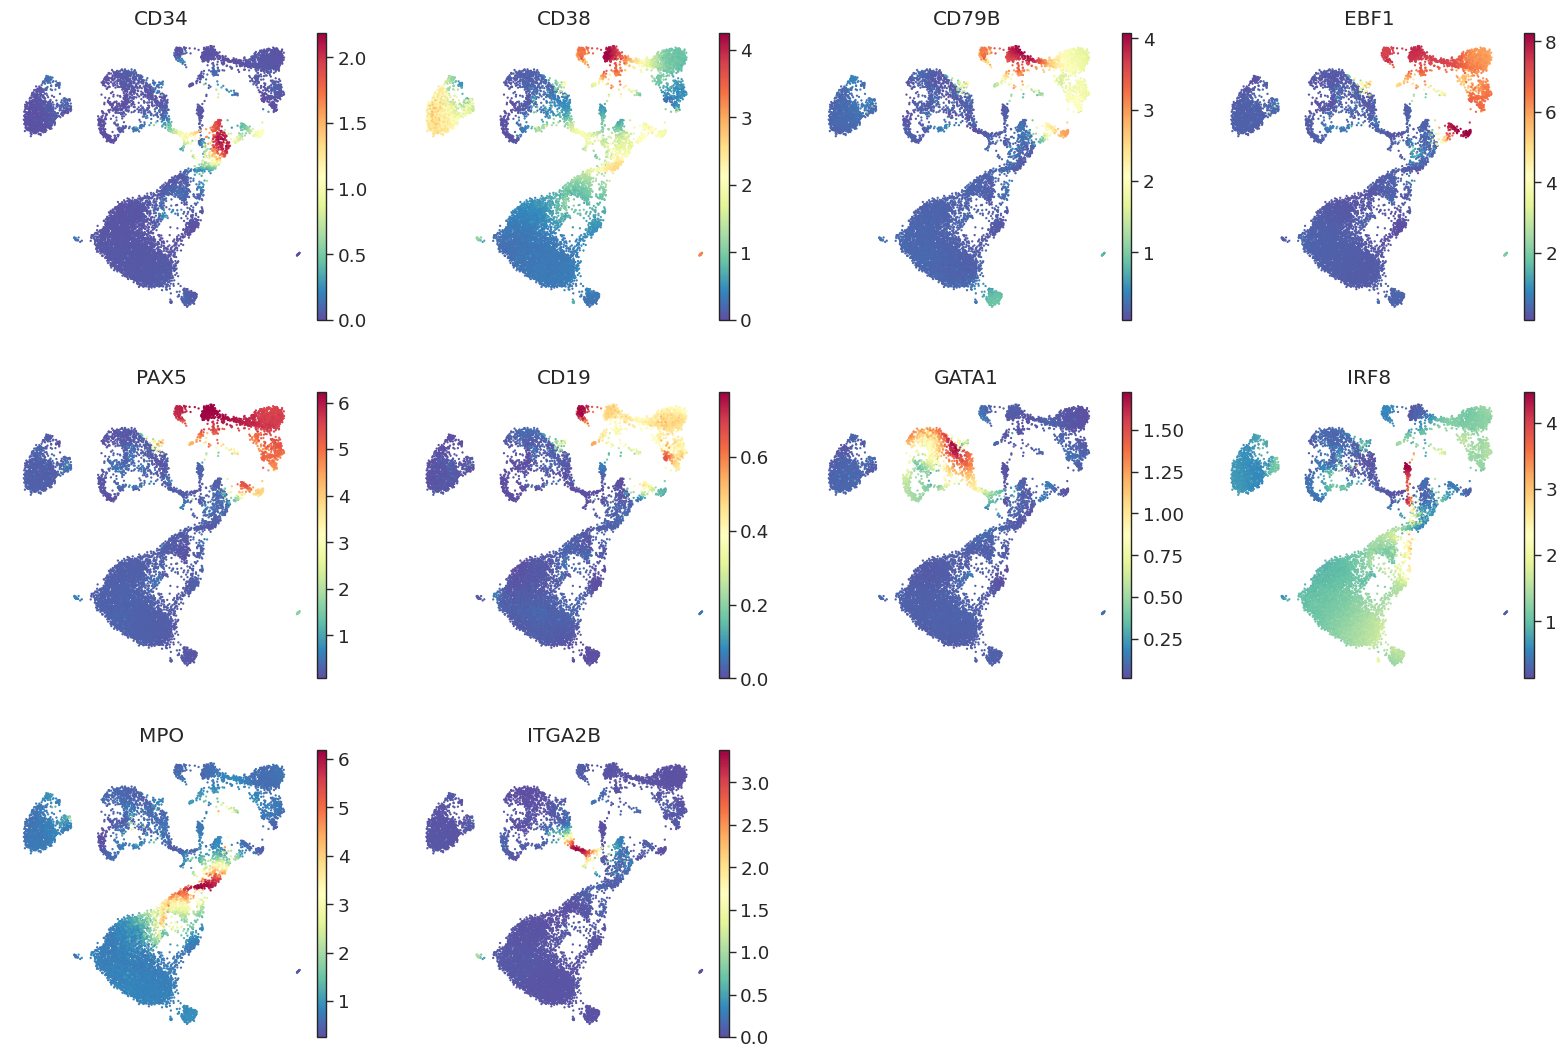

In [46]:
sc.pl.embedding(ad, basis='umap', color=genes, 
                layer='MAGIC_imputed_data', frameon=False) 

# Save

In [47]:
# Attach raw counts
ad.raw = sc.AnnData(raw_ad[ad.obs_names, :][:, ad.var_names].X)

In [48]:
ad.write(data_dir + 'bm_multiome_rna.h5ad')

In [49]:
# Export cell names for ATAC - only this subset of cells will be use for ATAC analysis
pd.DataFrame(ad.obs_names).to_csv(data_dir + 'bm_multiome_cells.csv')

In [50]:

data_dir

'multi-sample-multiome/'

In [51]:
!ls -ltrh $data_dir

total 2.1G
-rw-rw---- 1 cjordan2 setty_m_grp 1.2M Oct  2 10:25 rep1w
-rw-rw---- 1 cjordan2 setty_m_grp 3.0M Jan 11 17:30 features.tsv.gz
drwxrws--- 2 cjordan2 setty_m_grp  170 Jan 25 14:37 rep2
drwxrws--- 2 cjordan2 setty_m_grp  170 Jan 25 14:37 rep1
-rw-rw---- 1 cjordan2 setty_m_grp 1.7G Jan 25 14:41 bm_multiome_rna.h5ad
-rw-rw---- 1 cjordan2 setty_m_grp 441K Jan 25 14:41 bm_multiome_cells.csv
